In [ ]:
# Reusable plotting template with metrics box (MAE/RMSE) on every plot.
# Usage:
#   - Either let it compute metrics from the provided data, or pass your own values.
#   - Example (auto-compute): plot_test_series(raw=raw, title="Adults_8_Col")
#   - Example (given metrics): plot_test_series(raw=raw, title="Adults_8_Col", mae=6.12, rmse=9.45)
#
# Behavior:
# - Time plot: plots True & Predicted; marks BOTH True==0 dates and their Predicted points in RED.
# - Residuals over time: Predicted − True for non-missing rows.
# - Residual histogram.
# - True vs Predicted scatter with y=x; NaN-residual/True==0 points in RED.
# - Axis padding so edge/zero points are not clipped.
# - Metrics legend box (AnchoredText) added to each subplot.

# Update: On the time plot (Plot 1), the regular legend is forced to the TOP-LEFT
# to avoid overlap with the metrics box (which stays at metrics_loc, default "upper right").

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.offsetbox import AnchoredText
from typing import Optional
import io, re
from math import sqrt

def plot_test_series(raw: str = None,
                     df: pd.DataFrame = None,
                     title: str = "Adults_8_Col",
                     # Metrics: if None, will be computed from non-missing rows
                     mae: Optional[float] = None,
                     rmse: Optional[float] = None,
                     # Layout / formatting
                     date_pad_days: int = 3,
                     scatter_pad_frac: float = 0.06,
                     scatter_min_pad: float = 0.5,
                     metrics_loc: str = "upper right",     # where the MAE/RMSE box goes
                     time_legend_loc: str = "upper left",  # where the regular legend goes on Plot 1
                     other_legend_loc: str = "best",       # legend location on the other plots
                     metrics_fmt: str = "{:.1f}"):

    # ---- ingest ----
    if df is None:
        if raw is None:
            raise ValueError("Provide either `raw` (multiline string) or `df` (DataFrame).")
        data_lines = [ln for ln in raw.splitlines() if re.match(r'^\s*\d{4}-\d{2}-\d{2}', ln)]
        header_cols = ["Date", "True", "Predicted"]
        if any("was_missing" in ln for ln in raw.splitlines()):
            header_cols += ["was_missing"]
        if any(re.search(r"\bResidual\b", ln) for ln in raw.splitlines()):
            header_cols += ["Residual"]
        table = " ".join(header_cols) + "\n" + "\n".join(data_lines)
        df = pd.read_csv(io.StringIO(table), sep=r"\s+")
    else:
        df = df.copy()

    # ---- types ----
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date", ignore_index=True)

    # Mask for "Residual is NaN ⇔ True was 0 / held-out on TEST"
    if "was_missing" in df.columns:
        mask_nan = df["was_missing"].astype(str).str.lower().map({"true": True, "false": False}).fillna(False)
    else:
        mask_nan = (df["True"] == 0)

    # Residuals (recompute if missing)
    if "Residual" not in df.columns or df["Residual"].isna().all():
        df["Residual"] = np.where(~mask_nan, df["Predicted"] - df["True"], np.nan)

    # ---- compute metrics if not provided ----
    y_true = df.loc[~mask_nan, "True"].to_numpy()
    y_pred = df.loc[~mask_nan, "Predicted"].to_numpy()
    if mae is None:
        mae_val = float(np.mean(np.abs(y_pred - y_true))) if y_true.size else np.nan
    else:
        mae_val = float(mae)
    if rmse is None:
        rmse_val = float(sqrt(np.mean((y_pred - y_true) ** 2))) if y_true.size else np.nan
    else:
        rmse_val = float(rmse)

    def _metrics_box(ax):
        def _fmt(x):
            try:
                return metrics_fmt.format(x)
            except Exception:
                return str(x)
        txt = f"MAE: {_fmt(mae_val)}\nRMSE: {_fmt(rmse_val)}"
        at = AnchoredText(txt, loc=metrics_loc, prop=dict(size=10), frameon=True, borderpad=0.8)
        at.patch.set_alpha(0.75)
        ax.add_artist(at)

    def _legend_dedup(ax, loc="best"):
        handles, labels = ax.get_legend_handles_labels()
        if not labels:
            return
        dd = {}
        for h, l in zip(handles, labels):
            if l not in dd:
                dd[l] = h
        ax.legend(list(dd.values()), list(dd.keys()), loc=loc)

    date_pad = pd.Timedelta(days=int(date_pad_days))
    x_min = df["Date"].min() - date_pad
    x_max = df["Date"].max() + date_pad

    # ---- Plot 1: True vs Predicted over time ----
    fig, ax = plt.subplots(figsize=(11, 5))
    ax.plot(df["Date"], df["True"], marker="o", linewidth=1.5, label="True")
    ax.plot(df["Date"], df["Predicted"], marker="s", linewidth=1.5, label="Predicted")

    # Mark NaN-residual (True==0) for BOTH True and Predicted
    if mask_nan.any():
        ax.scatter(df.loc[mask_nan, "Date"], df.loc[mask_nan, "True"],
                   marker="o", s=90, color="red", zorder=5, label="True=0 (Residual NaN)")
        ax.scatter(df.loc[mask_nan, "Date"], df.loc[mask_nan, "Predicted"],
                   marker="s", s=90, color="red", zorder=5, label="Predicted at True=0")

    ax.set_xlim(x_min, x_max)
    ax.margins(x=0.0, y=0.06)
    ax.set_title(f"{title}: True vs Predicted - Site 8, 2015")
    ax.set_xlabel("Date")
    ax.set_ylabel("Count")
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)                        # stays at metrics_loc (e.g., upper right)
    _legend_dedup(ax, loc=time_legend_loc)  # force regular legend to top-left for Plot 1
    plt.tight_layout()

    # ---- Plot 2: Residuals over time ----
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.plot(df.loc[~mask_nan, "Date"], df.loc[~mask_nan, "Residual"], marker="o", linewidth=1.5)
    ax.set_xlim(x_min, x_max)
    ax.margins(x=0.0, y=0.08)
    ax.set_title(f"{title}: Residuals Over Time (Predicted − True) - Site 8, 2015")
    ax.set_xlabel("Date")
    ax.set_ylabel("Residual")
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()

    # ---- Plot 3: Residual distribution ----
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(df.loc[~mask_nan, "Residual"].dropna(), bins="auto")
    ax.set_title(f"{title}: Residual Distribution (Predicted − True) - Site 8, 2015")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()

    # ---- Plot 4: True vs Predicted (scatter) ----
    fig, ax = plt.subplots(figsize=(6.8, 6.8))
    x_true = df["True"].to_numpy()
    y_pred = df["Predicted"].to_numpy()
    ax.scatter(x_true[~mask_nan], y_pred[~mask_nan], marker="o", alpha=0.9, label="Observed")
    if mask_nan.any():
        ax.scatter(x_true[mask_nan], y_pred[mask_nan], marker="o", s=90, color="red", zorder=5,
                   label="NaN Residual (True=0)")

    data_min = float(min(x_true.min(), y_pred.min()))
    data_max = float(max(x_true.max(), y_pred.max()))
    span = max(1e-9, data_max - data_min)
    pad_val = max(float(scatter_min_pad), float(scatter_pad_frac) * span)
    lims = (data_min - pad_val, data_max + pad_val)
    ax.plot(lims, lims, linestyle="--", linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_title(f"{title}: True vs Predicted (Scatter) - Site 8, 2015")
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()

    plt.show()



# -------------- Example --------------
if __name__ == "__main__":
    raw = """            Date  True  Predicted  Baseline_prev  Baseline_mean
2015-07-01     0          1              5              5
2015-07-02     1          0              0              5
2015-07-03     2          1              1              5
2015-07-04     3          1              2              5
2015-07-05     0          2              3              5
2015-07-06     0          3              0              5
2015-07-07     0          0              0              5
2015-07-08     2          2              0              5
2015-07-09     0          1              2              5
2015-07-10     0          1              0              5
2015-07-11     0          4              0              5
2015-07-12     2          3              0              5
2015-07-13     2          1              2              5
2015-07-14     3          2              2              5
2015-07-15     2          1              3              5
2015-07-16     3          1              2              5
2015-07-17     8          2              3              5
2015-07-18    23          2              8              5
2015-07-19     0          2             23              5
2015-07-20     0          3              0              5
2015-07-21     0          2              0              5
2015-07-22     8          1              0              5
2015-07-23     5          2              8              5
2015-07-24     1          3              5              5
2015-07-25     2          3              1              5
2015-07-26     5          3              2              5
2015-07-27    12          2              5              5
2015-07-28    10          1             12              5
2015-07-29     2          2             10              5
2015-07-30     3          2              2              5
2015-07-31    37          2              3              5
2015-08-01     2          3             37              5
2015-08-02     4          2              2              5
2015-08-03     2          1              4              5
2015-08-04     0          3              2              5
2015-08-05     0          5              0              5
2015-08-06    10          2              0              5
2015-08-07     0          2             10              5
2015-08-08     3          3              0              5
2015-08-09     5          3              3              5
2015-08-10    22          3              5              5
2015-08-11     9          2             22              5
2015-08-12    10          1              9              5
2015-08-13     9          2             10              5
2015-08-14     7          2              9              5
2015-08-15    13          3              7              5
2015-08-16     3          2             13              5
2015-08-17    10          1              3              5
2015-08-18     3          3             10              5
2015-08-19     3          2              3              5
2015-08-20     5          3              3              5
2015-08-21     1          3              5              5
2015-08-22     5          2              1              5
2015-08-23     0          3              5              5
2015-08-24     1          3              0              5
2015-08-25     0          2              1              5
2015-08-26     1          0              0              5
2015-08-27     0          1              1              5
2015-08-28     4          4              0              5
2015-08-29     0          1              4              5
2015-08-30     0          1              0              5
2015-08-31     0          1              0              5
2015-09-01     1          0              0              5
2015-09-02     0          3              1              5
2015-09-03     1          2              0              5
2015-09-04     1          2              1              5
2015-09-05     5          1              1              5
2015-09-06     7          3              5              5
2015-09-07    19          1              7              5
2015-09-08    21          1             19              5
2015-09-09    20          3             21              5
2015-09-10    16          2             20              5
2015-09-11    13          1             16              5
2015-09-12     4          2             13              5
2015-09-13     6          2              4              5
2015-09-14     7          2              6              5
2015-09-15    21          1              7              5
2015-09-16     3          1             21              5
2015-09-17     1          3              3              5
2015-09-18    12          2              1              5
2015-09-19     9          0             12              5
2015-09-20    11          2              9              5
2015-09-21     4          2             11              5
2015-09-22     4          2              4              5
2015-09-23     4          2              4              5
2015-09-24     0          2              4              5
2015-09-25     1          1              0              5
2015-09-26     1          1              1              5
2015-09-27     4          2              1              5
2015-09-28     1          2              4              5
2015-09-29     5          2              1              5
2015-09-30     6          1              5              5
2015-10-01     2          2              6              5
2015-10-02     8          2              2              5
2015-10-03     2          2              8              5
2015-10-04     5          1              2              5
2015-10-05     9          2              5              5
2015-10-06    11          1              9              5
2015-10-07     2          2             11              5
2015-10-08     4          3              2              5
2015-10-09     2          2              4              5
2015-10-10     4          1              2              5
2015-10-11     0          2              4              5
2015-10-12     9          2              0              5
2015-10-13     1          2              9              5
2015-10-14     1          2              1              5
2015-10-15     7          2              1              5
2015-10-16     3          1              7              5
2015-10-17     5          1              3              5
2015-10-18     1          2              5              5
2015-10-19     1          1              1              5
2015-10-20     6          1              1              5
    """

    # Auto-computed metrics:
    #plot_test_series(raw=raw, title="Adults_8_Col")
    # Or pass your own values:
    plot_test_series(raw=raw, title="Adults_8_Gam0", mae=4.7222, rmse=6.0231)



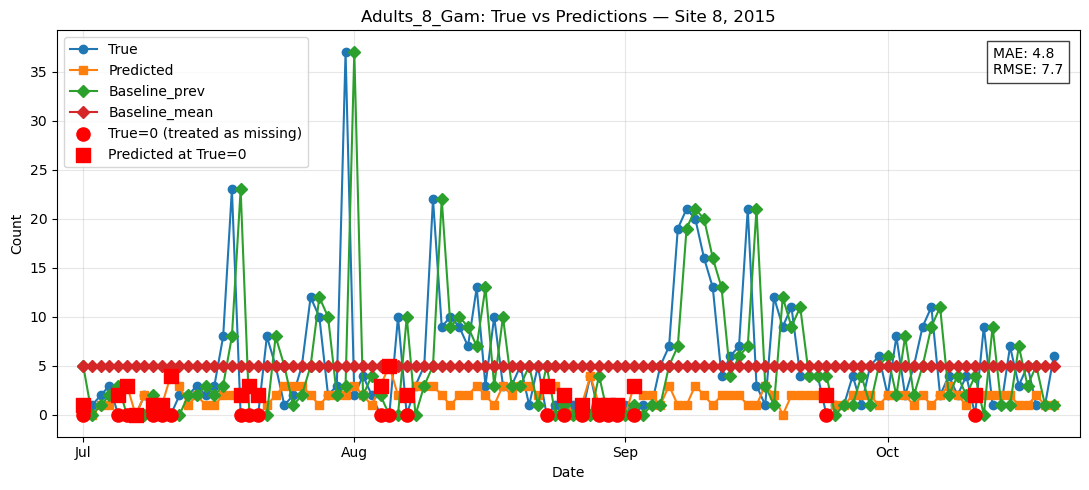

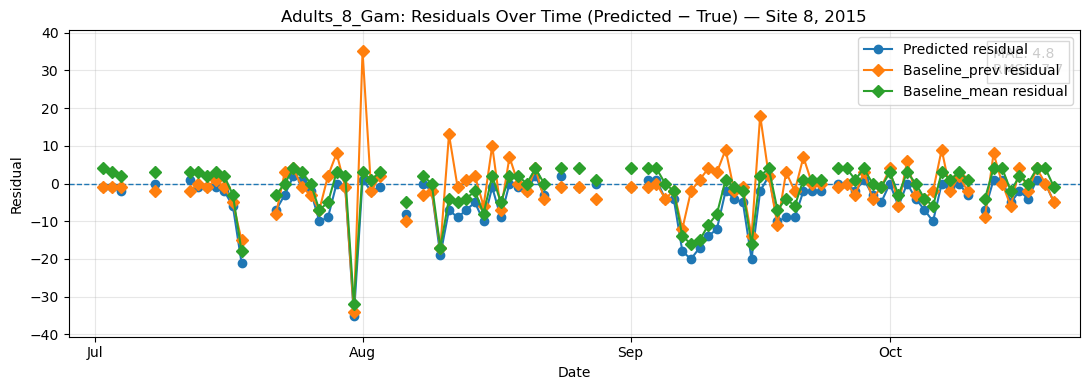

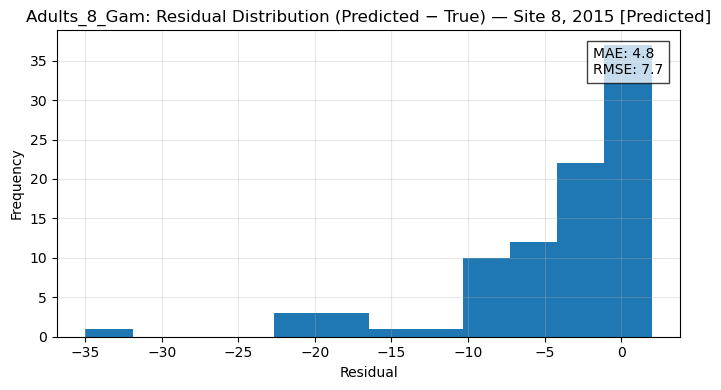

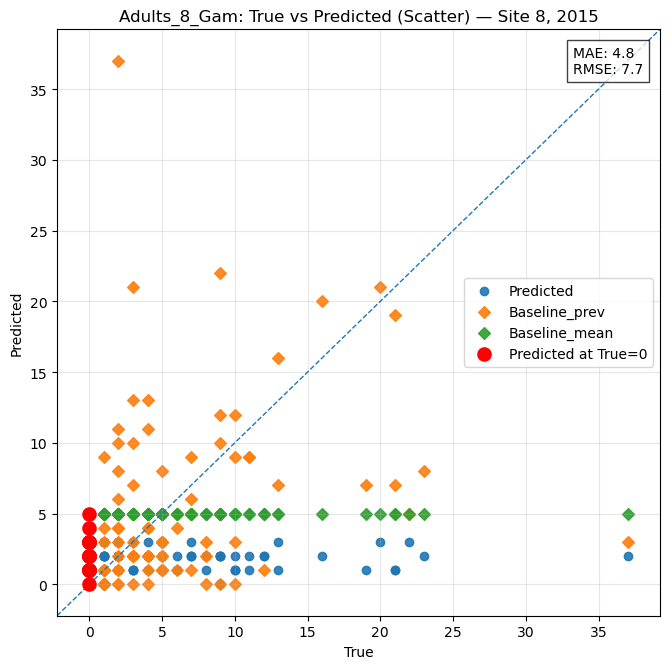

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.offsetbox import AnchoredText
from typing import Optional, List
import io, re
from math import sqrt

def plot_test_series(raw: str = None,
                     df: pd.DataFrame = None,
                     title: str = "Adults_8_Col",
                     subtitle: Optional[str] = "Site 8, 2015",
                     # Which prediction columns to plot; if None, auto-detect (all non-['Date','True'] numeric cols)
                     pred_cols: Optional[List[str]] = None,
                     # Which column’s metrics to compute & which gets red “True==0” markers
                     main_col: Optional[str] = "Predicted",
                     # Metrics: if None, will be computed on non-missing (True!=0) rows
                     mae: Optional[float] = None,
                     rmse: Optional[float] = None,
                     # Layout / formatting
                     date_pad_days: int = 3,
                     scatter_pad_frac: float = 0.06,
                     scatter_min_pad: float = 0.5,
                     metrics_loc: str = "upper right",     # where the MAE/RMSE box goes
                     time_legend_loc: str = "upper left",  # legend location on Plot 1
                     other_legend_loc: str = "best",       # legend on other plots
                     metrics_fmt: str = "{:.1f}"):

    # ---- ingest ----
    if df is None:
        if raw is None:
            raise ValueError("Provide either `raw` (multiline string) or `df` (DataFrame).")
        # Read as whitespace-delimited with header
        df = pd.read_csv(io.StringIO(raw.strip()), sep=r"\s+", engine="python")
    else:
        df = df.copy()

    # Basic columns
    if "Date" not in df.columns or "True" not in df.columns:
        raise ValueError("Input must contain columns: 'Date' and 'True'.")

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date", ignore_index=True)

    # Auto-detect prediction columns if not given
    if pred_cols is None:
        pred_cols = [c for c in df.columns if c not in ["Date", "True"]]
        # keep only numeric
        num_mask = []
        for c in pred_cols:
            try:
                pd.to_numeric(df[c], errors="raise")
                num_mask.append(True)
            except Exception:
                num_mask.append(False)
        pred_cols = [c for c, ok in zip(pred_cols, num_mask) if ok]

    if not pred_cols:
        raise ValueError("No prediction columns found. Pass `pred_cols=[...]` or include them in the data.")

    # Ensure numeric
    for c in ["True"] + pred_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Choose main_col
    if main_col is None or main_col not in pred_cols:
        main_col = pred_cols[0]  # fallback

    # ---- mask for 'missing on test' (True==0) ----
    mask_nan = (df["True"] == 0)

    # ---- residuals for main prediction ----
    df["Residual_main"] = np.where(~mask_nan, df[main_col] - df["True"], np.nan)

    # ---- compute metrics for main_col if not provided ----
    y_true = df.loc[~mask_nan, "True"].to_numpy()
    y_pred_main = df.loc[~mask_nan, main_col].to_numpy()
    if mae is None:
        mae_val = float(np.mean(np.abs(y_pred_main - y_true))) if y_true.size else np.nan
    else:
        mae_val = float(mae)
    if rmse is None:
        rmse_val = float(sqrt(np.mean((y_pred_main - y_true) ** 2))) if y_true.size else np.nan
    else:
        rmse_val = float(rmse)

    def _metrics_box(ax):
        def _fmt(x):
            try:
                return metrics_fmt.format(x)
            except Exception:
                return str(x)
        txt = f"MAE: {_fmt(mae_val)}\nRMSE: {_fmt(rmse_val)}"
        at = AnchoredText(txt, loc=metrics_loc, prop=dict(size=10), frameon=True, borderpad=0.8)
        at.patch.set_alpha(0.75)
        ax.add_artist(at)

    def _legend_dedup(ax, loc="best"):
        handles, labels = ax.get_legend_handles_labels()
        if not labels:
            return
        dd = {}
        for h, l in zip(handles, labels):
            if l not in dd:
                dd[l] = h
        ax.legend(list(dd.values()), list(dd.keys()), loc=loc)

    date_pad = pd.Timedelta(days=int(date_pad_days))
    x_min = df["Date"].min() - date_pad
    x_max = df["Date"].max() + date_pad

    title_suffix = f" — {subtitle}" if subtitle else ""

    # ---- Plot 1: True vs Predictions over time ----
    fig, ax = plt.subplots(figsize=(11, 5))
    ax.plot(df["Date"], df["True"], marker="o", linewidth=1.5, label="True")

    for c in pred_cols:
        mk = "s" if c == main_col else "D"
        ax.plot(df["Date"], df[c], marker=mk, linewidth=1.5, label=c)

    # Mark True==0 dates (both True and MAIN prediction) in red
    if mask_nan.any():
        ax.scatter(df.loc[mask_nan, "Date"], df.loc[mask_nan, "True"],
                   marker="o", s=90, color="red", zorder=5, label="True=0 (treated as missing)")
        ax.scatter(df.loc[mask_nan, "Date"], df.loc[mask_nan, main_col],
                   marker="s", s=90, color="red", zorder=5, label=f"{main_col} at True=0")

    ax.set_xlim(x_min, x_max)
    ax.margins(x=0.0, y=0.06)
    ax.set_title(f"{title}: True vs Predictions{title_suffix}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Count")
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)                        # metrics for MAIN prediction
    _legend_dedup(ax, loc=time_legend_loc)
    plt.tight_layout()

    # ---- Plot 2: Residuals over time (all preds) ----
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.axhline(0, linestyle="--", linewidth=1)
    for c in pred_cols:
        resid = np.where(~mask_nan, df[c] - df["True"], np.nan)
        mk = "o" if c == main_col else "D"
        ax.plot(df["Date"], resid, marker=mk, linewidth=1.5, label=f"{c} residual")
    ax.set_xlim(x_min, x_max)
    ax.margins(x=0.0, y=0.08)
    ax.set_title(f"{title}: Residuals Over Time (Predicted − True){title_suffix}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Residual")
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()

    # ---- Plot 3: Residual distribution (MAIN only) ----
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(pd.Series(df["Residual_main"]).dropna(), bins="auto")
    ax.set_title(f"{title}: Residual Distribution (Predicted − True){title_suffix} [{main_col}]")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()

    # ---- Plot 4: True vs Predicted (scatter) ----
    fig, ax = plt.subplots(figsize=(6.8, 6.8))
    x_true = df["True"].to_numpy()

    # Combine limits across all prediction columns
    data_min = np.nanmin(np.concatenate([x_true] + [df[c].to_numpy() for c in pred_cols]))
    data_max = np.nanmax(np.concatenate([x_true] + [df[c].to_numpy() for c in pred_cols]))
    span = max(1e-9, float(data_max - data_min))
    pad_val = max(float(scatter_min_pad), float(scatter_pad_frac) * span)
    lims = (float(data_min) - pad_val, float(data_max) + pad_val)

    for c in pred_cols:
        mask_obs = ~mask_nan & np.isfinite(df[c]) & np.isfinite(df["True"])
        ax.scatter(x_true[mask_obs], df[c].to_numpy()[mask_obs],
                   marker="o" if c == main_col else "D", alpha=0.9, label=c)

    # Red points for True==0 (MAIN prediction only)
    if mask_nan.any():
        ax.scatter(x_true[mask_nan], df[main_col].to_numpy()[mask_nan],
                   marker="o", s=90, color="red", zorder=5, label=f"{main_col} at True=0")

    ax.plot(lims, lims, linestyle="--", linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_title(f"{title}: True vs Predicted (Scatter){title_suffix}")
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()

    plt.show()


# ---------------- Example ----------------
if __name__ == "__main__":
    raw = """            Date  True  Predicted  Baseline_prev  Baseline_mean
2015-07-01     0          1              5              5
2015-07-02     1          0              0              5
2015-07-03     2          1              1              5
2015-07-04     3          1              2              5
2015-07-05     0          2              3              5
2015-07-06     0          3              0              5
2015-07-07     0          0              0              5
2015-07-08     2          2              0              5
2015-07-09     0          1              2              5
2015-07-10     0          1              0              5
2015-07-11     0          4              0              5
2015-07-12     2          3              0              5
2015-07-13     2          1              2              5
2015-07-14     3          2              2              5
2015-07-15     2          1              3              5
2015-07-16     3          1              2              5
2015-07-17     8          2              3              5
2015-07-18    23          2              8              5
2015-07-19     0          2             23              5
2015-07-20     0          3              0              5
2015-07-21     0          2              0              5
2015-07-22     8          1              0              5
2015-07-23     5          2              8              5
2015-07-24     1          3              5              5
2015-07-25     2          3              1              5
2015-07-26     5          3              2              5
2015-07-27    12          2              5              5
2015-07-28    10          1             12              5
2015-07-29     2          2             10              5
2015-07-30     3          2              2              5
2015-07-31    37          2              3              5
2015-08-01     2          3             37              5
2015-08-02     4          2              2              5
2015-08-03     2          1              4              5
2015-08-04     0          3              2              5
2015-08-05     0          5              0              5
2015-08-06    10          2              0              5
2015-08-07     0          2             10              5
2015-08-08     3          3              0              5
2015-08-09     5          3              3              5
2015-08-10    22          3              5              5
2015-08-11     9          2             22              5
2015-08-12    10          1              9              5
2015-08-13     9          2             10              5
2015-08-14     7          2              9              5
2015-08-15    13          3              7              5
2015-08-16     3          2             13              5
2015-08-17    10          1              3              5
2015-08-18     3          3             10              5
2015-08-19     3          2              3              5
2015-08-20     5          3              3              5
2015-08-21     1          3              5              5
2015-08-22     5          2              1              5
2015-08-23     0          3              5              5
2015-08-24     1          3              0              5
2015-08-25     0          2              1              5
2015-08-26     1          0              0              5
2015-08-27     0          1              1              5
2015-08-28     4          4              0              5
2015-08-29     0          1              4              5
2015-08-30     0          1              0              5
2015-08-31     0          1              0              5
2015-09-01     1          0              0              5
2015-09-02     0          3              1              5
2015-09-03     1          2              0              5
2015-09-04     1          2              1              5
2015-09-05     5          1              1              5
2015-09-06     7          3              5              5
2015-09-07    19          1              7              5
2015-09-08    21          1             19              5
2015-09-09    20          3             21              5
2015-09-10    16          2             20              5
2015-09-11    13          1             16              5
2015-09-12     4          2             13              5
2015-09-13     6          2              4              5
2015-09-14     7          2              6              5
2015-09-15    21          1              7              5
2015-09-16     3          1             21              5
2015-09-17     1          3              3              5
2015-09-18    12          2              1              5
2015-09-19     9          0             12              5
2015-09-20    11          2              9              5
2015-09-21     4          2             11              5
2015-09-22     4          2              4              5
2015-09-23     4          2              4              5
2015-09-24     0          2              4              5
2015-09-25     1          1              0              5
2015-09-26     1          1              1              5
2015-09-27     4          2              1              5
2015-09-28     1          2              4              5
2015-09-29     5          2              1              5
2015-09-30     6          1              5              5
2015-10-01     2          2              6              5
2015-10-02     8          2              2              5
2015-10-03     2          2              8              5
2015-10-04     5          1              2              5
2015-10-05     9          2              5              5
2015-10-06    11          1              9              5
2015-10-07     2          2             11              5
2015-10-08     4          3              2              5
2015-10-09     2          2              4              5
2015-10-10     4          1              2              5
2015-10-11     0          2              4              5
2015-10-12     9          2              0              5
2015-10-13     1          2              9              5
2015-10-14     1          2              1              5
2015-10-15     7          2              1              5
2015-10-16     3          1              7              5
2015-10-17     5          1              3              5
2015-10-18     1          2              5              5
2015-10-19     1          1              1              5
2015-10-20     6          1              1              5
    """

    plot_test_series(raw=raw,
                     title="Adults_8_Gam",
                     pred_cols=["Predicted","Baseline_prev","Baseline_mean"],
                     main_col="Predicted",
                     subtitle="Site 8, 2015")


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.offsetbox import AnchoredText
from typing import Optional, List, Dict, Tuple
from math import sqrt
from pathlib import Path
import io, re

def plot_test_series(raw: str = None,
                     df: pd.DataFrame = None,
                     title: str = "Adults_8_Col",
                     subtitle: Optional[str] = "Site 8, 2015",
                     pred_cols: Optional[List[str]] = None,  # if None, auto-detect NON-baseline preds
                     main_col: Optional[str] = "Predicted",  # metrics/highlight based on this column
                     mae: Optional[float] = None,
                     rmse: Optional[float] = None,
                     date_pad_days: int = 3,
                     scatter_pad_frac: float = 0.06,
                     scatter_min_pad: float = 0.5,
                     metrics_loc: str = "upper right",
                     time_legend_loc: str = "upper left",
                     other_legend_loc: str = "best",
                     metrics_fmt: str = "{:.1f}",
                     # saving
                     save_pdf: bool = False,
                     out_dir: str = "plots",
                     file_prefix: Optional[str] = None,
                     show: bool = True) -> Dict[str, str]:
    """
    Returns:
        dict mapping plot-name -> saved PDF path (empty if save_pdf=False)

    Behavior:
      - Treats True==0 as "missing-on-test" (residuals NaN, highlighted in red)
      - Plots only non-baseline prediction columns (auto) unless pred_cols provided
      - Saves each plot as its own PDF if save_pdf=True
    """

    # ---- ingest ----
    if df is None:
        if raw is None:
            raise ValueError("Provide either `raw` (multiline string) or `df` (DataFrame).")
        df = pd.read_csv(io.StringIO(raw.strip()), sep=r"\s+", engine="python")
    else:
        df = df.copy()

    if "Date" not in df.columns or "True" not in df.columns:
        raise ValueError("Input must contain columns: 'Date' and 'True'.")

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date", ignore_index=True)

    # ---- auto-detect prediction columns, excluding baselines ----
    if pred_cols is None:
        cand = [c for c in df.columns if c not in ["Date", "True"]]
        # drop anything that looks like a baseline (case-insensitive)
        cand = [c for c in cand if not re.match(r"(?i)^baseline", str(c))]
        # keep only numeric columns
        preds = []
        for c in cand:
            try:
                pd.to_numeric(df[c], errors="raise")
                preds.append(c)
            except Exception:
                pass
        pred_cols = preds

    if not pred_cols:
        # if everything was baseline, try to fall back to 'Predicted' if present
        if "Predicted" in df.columns:
            pred_cols = ["Predicted"]
        else:
            raise ValueError("No non-baseline prediction columns found. Pass `pred_cols=[...]` explicitly.")

    # ensure numeric
    for c in ["True"] + pred_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # choose main_col
    if main_col is None or main_col not in pred_cols:
        main_col = pred_cols[0]

    # ---- mask for 'missing on test' (True==0) ----
    mask_nan = (df["True"] == 0)

    # ---- residuals + metrics for main prediction ----
    df["Residual_main"] = np.where(~mask_nan, df[main_col] - df["True"], np.nan)

    y_true = df.loc[~mask_nan, "True"].to_numpy()
    y_pred_main = df.loc[~mask_nan, main_col].to_numpy()

    if mae is None:
        mae_val = float(np.mean(np.abs(y_pred_main - y_true))) if y_true.size else np.nan
    else:
        mae_val = float(mae)

    if rmse is None:
        rmse_val = float(np.sqrt(np.mean((y_pred_main - y_true) ** 2))) if y_true.size else np.nan
    else:
        rmse_val = float(rmse)

    def _metrics_box(ax):
        def _fmt(x):
            try:
                return metrics_fmt.format(x)
            except Exception:
                return str(x)
        txt = f"MAE: {_fmt(mae_val)}\nRMSE: {_fmt(rmse_val)}"
        at = AnchoredText(txt, loc=metrics_loc, prop=dict(size=10), frameon=True, borderpad=0.8)
        at.patch.set_alpha(0.75)
        ax.add_artist(at)

    def _legend_dedup(ax, loc="best"):
        handles, labels = ax.get_legend_handles_labels()
        if not labels:
            return
        uniq = {}
        for h, l in zip(handles, labels):
            if l not in uniq:
                uniq[l] = h
        ax.legend(list(uniq.values()), list(uniq.keys()), loc=loc)

    date_pad = pd.Timedelta(days=int(date_pad_days))
    x_min = df["Date"].min() - date_pad
    x_max = df["Date"].max() + date_pad
    title_suffix = f" — {subtitle}" if subtitle else ""

    # ---- saving helpers ----
    saved_paths: Dict[str, str] = {}
    figs: List[Tuple[str, plt.Figure]] = []

    def _clean_prefix(s: str) -> str:
        return re.sub(r"[^A-Za-z0-9._-]+", "_", s).strip("_")

    prefix = _clean_prefix(file_prefix if file_prefix else title)
    out_path = Path(out_dir)
    if save_pdf:
        out_path.mkdir(parents=True, exist_ok=True)

    def _save(fig: plt.Figure, tag: str):
        if save_pdf:
            fname = f"{prefix}__{tag}.pdf"
            fpath = out_path / fname
            fig.savefig(fpath, format="pdf", bbox_inches="tight")
            saved_paths[tag] = str(fpath)

    # ---- Plot 1: True vs Predictions over time ----
    fig, ax = plt.subplots(figsize=(11, 5))
    ax.plot(df["Date"], df["True"], marker="o", linewidth=1.5, label="True")

    for c in pred_cols:
        mk = "s" if c == main_col else "D"
        ax.plot(df["Date"], df[c], marker=mk, linewidth=1.5, label=c)

    if mask_nan.any():
        ax.scatter(df.loc[mask_nan, "Date"], df.loc[mask_nan, "True"],
                   marker="o", s=90, color="red", zorder=5, label="True=0 (treated as missing)")
        ax.scatter(df.loc[mask_nan, "Date"], df.loc[mask_nan, main_col],
                   marker="s", s=90, color="red", zorder=5, label=f"{main_col} at True=0")

    ax.set_xlim(x_min, x_max)
    ax.margins(x=0.0, y=0.06)
    ax.set_title(f"{title}: True vs Predictions{title_suffix}")
    ax.set_xlabel("Date"); ax.set_ylabel("Count")
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=time_legend_loc)
    plt.tight_layout()
    _save(fig, "time_series")
    figs.append(("time_series", fig))

    # ---- Plot 2: Residuals over time (all preds) ----
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.axhline(0, linestyle="--", linewidth=1)
    for c in pred_cols:
        resid = np.where(~mask_nan, df[c] - df["True"], np.nan)
        mk = "o" if c == main_col else "D"
        ax.plot(df["Date"], resid, marker=mk, linewidth=1.5, label=f"{c} residual")
    ax.set_xlim(x_min, x_max)
    ax.margins(x=0.0, y=0.08)
    ax.set_title(f"{title}: Residuals Over Time (Predicted − True){title_suffix}")
    ax.set_xlabel("Date"); ax.set_ylabel("Residual")
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()
    _save(fig, "residuals_over_time")
    figs.append(("residuals_over_time", fig))

    # ---- Plot 3: Residual distribution (MAIN only) ----
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(pd.Series(df["Residual_main"]).dropna(), bins="auto")
    ax.set_title(f"{title}: Residual Distribution (Predicted − True){title_suffix} [{main_col}]")
    ax.set_xlabel("Residual"); ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()
    _save(fig, "residual_hist")
    figs.append(("residual_hist", fig))

    # ---- Plot 4: True vs Predicted (scatter) ----
    fig, ax = plt.subplots(figsize=(6.8, 6.8))
    x_true = df["True"].to_numpy()
    data_min = np.nanmin(np.concatenate([x_true] + [df[c].to_numpy() for c in pred_cols]))
    data_max = np.nanmax(np.concatenate([x_true] + [df[c].to_numpy() for c in pred_cols]))
    span = max(1e-9, float(data_max - data_min))
    pad_val = max(float(scatter_min_pad), float(scatter_pad_frac) * span)
    lims = (float(data_min) - pad_val, float(data_max) + pad_val)

    for c in pred_cols:
        mask_obs = ~mask_nan & np.isfinite(df[c]) & np.isfinite(df["True"])
        ax.scatter(x_true[mask_obs], df[c].to_numpy()[mask_obs],
                   marker="o" if c == main_col else "D", alpha=0.9, label=c)

    if mask_nan.any():
        ax.scatter(x_true[mask_nan], df[main_col].to_numpy()[mask_nan],
                   marker="o", s=90, color="red", zorder=5, label=f"{main_col} at True=0")

    ax.plot(lims, lims, linestyle="--", linewidth=1)
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel("True"); ax.set_ylabel("Predicted")
    ax.set_title(f"{title}: True vs Predicted (Scatter){title_suffix}")
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()
    _save(fig, "true_vs_pred_scatter")
    figs.append(("true_vs_pred_scatter", fig))

    # ---- show/close & return ----
    if show:
        plt.show()
    else:
        for _, f in figs:
            plt.close(f)

    return saved_paths


# ---------------- Example ----------------
if __name__ == "__main__":
    raw = """            Date  True  Predicted  Baseline_prev  Baseline_mean
2015-07-01     0          1              5              5
2015-07-02     1          0              0              5
2015-07-03     2          1              1              5
2015-07-04     3          1              2              5
2015-07-05     0          2              3              5
2015-07-06     0          3              0              5
2015-07-07     0          0              0              5
2015-07-08     2          2              0              5
2015-07-09     0          1              2              5
2015-07-10     0          1              0              5
2015-07-11     0          4              0              5
2015-07-12     2          3              0              5
2015-07-13     2          1              2              5
2015-07-14     3          2              2              5
2015-07-15     2          1              3              5
2015-07-16     3          1              2              5
2015-07-17     8          2              3              5
2015-07-18    23          2              8              5
2015-07-19     0          2             23              5
2015-07-20     0          3              0              5
2015-07-21     0          2              0              5
2015-07-22     8          1              0              5
2015-07-23     5          2              8              5
2015-07-24     1          3              5              5
2015-07-25     2          3              1              5
2015-07-26     5          3              2              5
2015-07-27    12          2              5              5
2015-07-28    10          1             12              5
2015-07-29     2          2             10              5
2015-07-30     3          2              2              5
2015-07-31    37          2              3              5
2015-08-01     2          3             37              5
2015-08-02     4          2              2              5
2015-08-03     2          1              4              5
2015-08-04     0          3              2              5
2015-08-05     0          5              0              5
2015-08-06    10          2              0              5
2015-08-07     0          2             10              5
2015-08-08     3          3              0              5
2015-08-09     5          3              3              5
2015-08-10    22          3              5              5
2015-08-11     9          2             22              5
2015-08-12    10          1              9              5
2015-08-13     9          2             10              5
2015-08-14     7          2              9              5
2015-08-15    13          3              7              5
2015-08-16     3          2             13              5
2015-08-17    10          1              3              5
2015-08-18     3          3             10              5
2015-08-19     3          2              3              5
2015-08-20     5          3              3              5
2015-08-21     1          3              5              5
2015-08-22     5          2              1              5
2015-08-23     0          3              5              5
2015-08-24     1          3              0              5
2015-08-25     0          2              1              5
2015-08-26     1          0              0              5
2015-08-27     0          1              1              5
2015-08-28     4          4              0              5
2015-08-29     0          1              4              5
2015-08-30     0          1              0              5
2015-08-31     0          1              0              5
2015-09-01     1          0              0              5
2015-09-02     0          3              1              5
2015-09-03     1          2              0              5
2015-09-04     1          2              1              5
2015-09-05     5          1              1              5
2015-09-06     7          3              5              5
2015-09-07    19          1              7              5
2015-09-08    21          1             19              5
2015-09-09    20          3             21              5
2015-09-10    16          2             20              5
2015-09-11    13          1             16              5
2015-09-12     4          2             13              5
2015-09-13     6          2              4              5
2015-09-14     7          2              6              5
2015-09-15    21          1              7              5
2015-09-16     3          1             21              5
2015-09-17     1          3              3              5
2015-09-18    12          2              1              5
2015-09-19     9          0             12              5
2015-09-20    11          2              9              5
2015-09-21     4          2             11              5
2015-09-22     4          2              4              5
2015-09-23     4          2              4              5
2015-09-24     0          2              4              5
2015-09-25     1          1              0              5
2015-09-26     1          1              1              5
2015-09-27     4          2              1              5
2015-09-28     1          2              4              5
2015-09-29     5          2              1              5
2015-09-30     6          1              5              5
2015-10-01     2          2              6              5
2015-10-02     8          2              2              5
2015-10-03     2          2              8              5
2015-10-04     5          1              2              5
2015-10-05     9          2              5              5
2015-10-06    11          1              9              5
2015-10-07     2          2             11              5
2015-10-08     4          3              2              5
2015-10-09     2          2              4              5
2015-10-10     4          1              2              5
2015-10-11     0          2              4              5
2015-10-12     9          2              0              5
2015-10-13     1          2              9              5
2015-10-14     1          2              1              5
2015-10-15     7          2              1              5
2015-10-16     3          1              7              5
2015-10-17     5          1              3              5
2015-10-18     1          2              5              5
2015-10-19     1          1              1              5
2015-10-20     6          1              1              5
    """

    # Baseline_* columns are automatically ignored
    paths = plot_test_series(
        raw=raw,
        title="Site 8, A. Gam - Single response XGBoost",
        # subtitle="Site 8, 2015",
        save_pdf=True,
        out_dir="plots",
        show=False
    )
    print(paths)


{'time_series': 'plots/Site_8_A._Gam_-_Single_response_XGBoost__time_series.pdf', 'residuals_over_time': 'plots/Site_8_A._Gam_-_Single_response_XGBoost__residuals_over_time.pdf', 'residual_hist': 'plots/Site_8_A._Gam_-_Single_response_XGBoost__residual_hist.pdf', 'true_vs_pred_scatter': 'plots/Site_8_A._Gam_-_Single_response_XGBoost__true_vs_pred_scatter.pdf'}


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.offsetbox import AnchoredText
from typing import Optional, List, Dict, Tuple
from math import sqrt
from pathlib import Path
import io, re
TICK_LABEL_SIZE = 14
LEGEND_FONT_SIZE = 12
AXIS_LABEL_SIZE = 14
def plot_test_series(raw: str = None,
                     df: pd.DataFrame = None,
                     title: str = "Adults_8_Gam",
                     subtitle: Optional[str] = "",
                     pred_cols: Optional[List[str]] = None,  # if None, auto-detect NON-baseline preds
                     main_col: Optional[str] = "Predicted",  # metrics/highlight based on this column
                     mae: Optional[float] = 4.886,
                     rmse: Optional[float] = 8.041,
                     date_pad_days: int = 3,
                     scatter_pad_frac: float = 0.06,
                     scatter_min_pad: float = 0.5,
                     metrics_loc: str = "upper right",
                     time_legend_loc: str = "upper left",
                     other_legend_loc: str = "best",
                     metrics_fmt: str = "{:.3f}",
                     # saving
                     save_pdf: bool = False,
                     out_dir: str = "plots",
                     file_prefix: Optional[str] = None,
                     show: bool = True) -> Dict[str, str]:
    """
    Returns:
        dict mapping plot-name -> saved PDF path (empty if save_pdf=False)

    Behavior:
      - Treats True==0 as "missing-on-test" (residuals NaN, highlighted in red)
      - Plots only non-baseline prediction columns (auto) unless pred_cols provided
      - Saves each plot as its own PDF if save_pdf=True
    """

    # ---- ingest ----
    if df is None:
        if raw is None:
            raise ValueError("Provide either `raw` (multiline string) or `df` (DataFrame).")
        df = pd.read_csv(io.StringIO(raw.strip()), sep=r"\s+", engine="python")
    else:
        df = df.copy()

    if "Date" not in df.columns or "True" not in df.columns:
        raise ValueError("Input must contain columns: 'Date' and 'True'.")

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date", ignore_index=True)

    # ---- auto-detect prediction columns, excluding baselines ----
    if pred_cols is None:
        cand = [c for c in df.columns if c not in ["Date", "True"]]
        # drop anything that looks like a baseline (case-insensitive)
        cand = [c for c in cand if not re.match(r"(?i)^baseline", str(c))]
        # keep only numeric columns
        preds = []
        for c in cand:
            try:
                pd.to_numeric(df[c], errors="raise")
                preds.append(c)
            except Exception:
                pass
        pred_cols = preds

    if not pred_cols:
        # if everything was baseline, try to fall back to 'Predicted' if present
        if "Predicted" in df.columns:
            pred_cols = ["Predicted"]
        else:
            raise ValueError("No non-baseline prediction columns found. Pass `pred_cols=[...]` explicitly.")

    # ensure numeric
    for c in ["True"] + pred_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # choose main_col
    if main_col is None or main_col not in pred_cols:
        main_col = pred_cols[0]

    # ---- mask for 'missing on test' (True==0) ----
    mask_nan = (df["True"] == 0)

    # ---- residuals + metrics for main prediction ----
    df["Residual_main"] = np.where(~mask_nan, df[main_col] - df["True"], np.nan)

    y_true = df.loc[~mask_nan, "True"].to_numpy()
    y_pred_main = df.loc[~mask_nan, main_col].to_numpy()

    if mae is None:
        mae_val = float(np.mean(np.abs(y_pred_main - y_true))) if y_true.size else np.nan
    else:
        mae_val = float(mae)

    if rmse is None:
        rmse_val = float(np.sqrt(np.mean((y_pred_main - y_true) ** 2))) if y_true.size else np.nan
    else:
        rmse_val = float(rmse)

    def _metrics_box(ax):
        def _fmt(x):
            try:
                return metrics_fmt.format(x)
            except Exception:
                return str(x)
        txt = f"MAE: {_fmt(mae_val)}\nRMSE: {_fmt(rmse_val)}"
        at = AnchoredText(txt, loc=metrics_loc, prop=dict(size=17), frameon=True, borderpad=0.8)
        at.patch.set_alpha(0.75)
        ax.add_artist(at)

    def _legend_dedup(ax, loc="best"):
        handles, labels = ax.get_legend_handles_labels()
        if not labels:
            return
        uniq = {}
        for h, l in zip(handles, labels):
            if l not in uniq:
                uniq[l] = h
        ax.legend(list(uniq.values()), list(uniq.keys()), loc=loc)

    date_pad = pd.Timedelta(days=int(date_pad_days))
    x_min = df["Date"].min() - date_pad
    x_max = df["Date"].max() + date_pad
    title_suffix = f" — {subtitle}" if subtitle else ""

    # ---- saving helpers ----
    saved_paths: Dict[str, str] = {}
    figs: List[Tuple[str, plt.Figure]] = []

    def _clean_prefix(s: str) -> str:
        return re.sub(r"[^A-Za-z0-9._-]+", "_", s).strip("_")

    prefix = _clean_prefix(file_prefix if file_prefix else title)
    out_path = Path(out_dir)
    if save_pdf:
        out_path.mkdir(parents=True, exist_ok=True)

    def _save(fig: plt.Figure, tag: str):
        if save_pdf:
            fname = f"{prefix}__{tag}.pdf"
            fpath = out_path / fname
            fig.savefig(fpath, format="pdf", bbox_inches="tight")
            saved_paths[tag] = str(fpath)

    # ---- Plot 1: True vs Predictions over time ----
    fig, ax = plt.subplots(figsize=(11, 5))
    ax.plot(df["Date"], df["True"], marker="o", linewidth=1.5, label="True")

    for c in pred_cols:
        mk = "s" if c == main_col else "D"
        ax.plot(df["Date"], df[c], marker=mk, linewidth=1.5, label=c)

    if mask_nan.any():
        ax.scatter(df.loc[mask_nan, "Date"], df.loc[mask_nan, "True"],
                   marker="o", s=90, color="red", zorder=5, label="True=0 (treated as missing)")
        ax.scatter(df.loc[mask_nan, "Date"], df.loc[mask_nan, main_col],
                   marker="s", s=90, color="red", zorder=5, label=f"{main_col} at True=0")

    ax.set_xlim(x_min, x_max)
    ax.margins(x=0.0, y=0.06)
    #ax.set_title(f"{title}: True vs Predicted{title_suffix}")
    ax.set_xlabel("Date", fontsize=AXIS_LABEL_SIZE)
    ax.set_ylabel("A. coluzzii count (Site 8)", fontsize=AXIS_LABEL_SIZE)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=time_legend_loc)
    #ax.legend(loc="best", fontsize=LEGEND_FONT_SIZE)
    ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE)
    plt.tight_layout()
    _save(fig, "time_series")
    figs.append(("time_series", fig))

    # ---- Plot 2: Residuals over time (all preds) ----
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.axhline(0, linestyle="--", linewidth=1)
    for c in pred_cols:
        resid = np.where(~mask_nan, df[c] - df["True"], np.nan)
        mk = "o" if c == main_col else "D"
        ax.plot(df["Date"], resid, marker=mk, linewidth=1.5, label=f"{c} residual")
    ax.set_xlim(x_min, x_max)
    ax.margins(x=0.0, y=0.08)
    ax.set_title(f"{title}: Residuals Over Time (Predicted − True){title_suffix}")
    ax.set_xlabel("Date"); ax.set_ylabel("Residual")
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()
    _save(fig, "residuals_over_time")
    figs.append(("residuals_over_time", fig))

    # ---- Plot 3: Residual distribution (MAIN only) ----
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(pd.Series(df["Residual_main"]).dropna(), bins="auto")
    ax.set_title(f"{title}: Residual Distribution (Predicted − True){title_suffix} [{main_col}]")
    ax.set_xlabel("Residual"); ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()
    _save(fig, "residual_hist")
    figs.append(("residual_hist", fig))

    # ---- Plot 4: True vs Predicted (scatter) ----
    fig, ax = plt.subplots(figsize=(6.8, 6.8))
    x_true = df["True"].to_numpy()
    data_min = np.nanmin(np.concatenate([x_true] + [df[c].to_numpy() for c in pred_cols]))
    data_max = np.nanmax(np.concatenate([x_true] + [df[c].to_numpy() for c in pred_cols]))
    span = max(1e-9, float(data_max - data_min))
    pad_val = max(float(scatter_min_pad), float(scatter_pad_frac) * span)
    lims = (float(data_min) - pad_val, float(data_max) + pad_val)

    for c in pred_cols:
        mask_obs = ~mask_nan & np.isfinite(df[c]) & np.isfinite(df["True"])
        ax.scatter(x_true[mask_obs], df[c].to_numpy()[mask_obs],
                   marker="o" if c == main_col else "D", alpha=0.9, label=c)

    if mask_nan.any():
        ax.scatter(x_true[mask_nan], df[main_col].to_numpy()[mask_nan],
                   marker="o", s=90, color="red", zorder=5, label=f"{main_col} at True=0")

    ax.plot(lims, lims, linestyle="--", linewidth=1)
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel("True"); ax.set_ylabel("Predicted")
    ax.set_title(f"{title}: True vs Predicted (Scatter){title_suffix}")
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()
    _save(fig, "true_vs_pred_scatter")
    figs.append(("true_vs_pred_scatter", fig))

    # ---- show/close & return ----
    if show:
        plt.show()
    else:
        for _, f in figs:
            plt.close(f)

    return saved_paths

# ---------------- Example ----------------
if __name__ == "__main__":
    raw = """      Date  True  Predicted  Baseline_prev  Baseline_mean
2015-07-01     0          0              5              5
2015-07-02     0          0              0              5
2015-07-03     0          0              0              5
2015-07-04     0          1              0              5
2015-07-05     2          0              0              5
2015-07-06     0          0              2              5
2015-07-07     6          4              0              5
2015-07-08     2          1              6              5
2015-07-09     1          3              2              5
2015-07-10     0          2              1              5
2015-07-11     0          5              0              5
2015-07-12     1          5              0              5
2015-07-13     1          1              1              5
2015-07-14     0          1              1              5
2015-07-15     0          1              0              5
2015-07-16     0          2              0              5
2015-07-17     3          3              0              5
2015-07-18     8          1              3              5
2015-07-19     2          2              8              5
2015-07-20     0          3              2              5
2015-07-21     0          1              0              5
2015-07-22     1          1              0              5
2015-07-23     0          2              1              5
2015-07-24     0          1              0              5
2015-07-25     2          5              0              5
2015-07-26     3         11              2              5
2015-07-27     3          1              3              5
2015-07-28     1          1              3              5
2015-07-29     2          0              1              5
2015-07-30     2          1              2              5
2015-07-31    15          2              2              5
2015-08-01     2          4             15              5
2015-08-02     1          3              2              5
2015-08-03     2          1              1              5
2015-08-04     3          4              2              5
2015-08-05     1          3              3              5
2015-08-06     6          3              1              5
2015-08-07     0          3              6              5
2015-08-08     1          4              0              5
2015-08-09     4          6              1              5
2015-08-10    27          7              4              5
2015-08-11    18          1             27              5
2015-08-12    22          1             18              5
2015-08-13     5          3             22              5
2015-08-14    11          3              5              5
2015-08-15    17          3             11              5
2015-08-16    27          3             17              5
2015-08-17    33          3             27              5
2015-08-18     9          6             33              5
2015-08-19     1          1              9              5
2015-08-20    13          4              1              5
2015-08-21     0          7             13              5
2015-08-22    19          2              0              5
2015-08-23     1          2             19              5
2015-08-24     1          4              1              5
2015-08-25     0          2              1              5
2015-08-26     0          1              0              5
2015-08-27     0          2              0              5
2015-08-28    18          0              0              5
2015-08-29     1          1             18              5
2015-08-30     1          7              1              5
2015-08-31     1          2              1              5
2015-09-01     3          1              1              5
2015-09-02     0          6              3              5
2015-09-03    12          1              0              5
2015-09-04     5          2             12              5
2015-09-05     6          2              5              5
2015-09-06    15          4              6              5
2015-09-07    24          2             15              5
2015-09-08    24          6             24              5
2015-09-09    10          4             24              5
2015-09-10    30          7             10              5
2015-09-11     5          7             30              5
2015-09-12     3          3              5              5
2015-09-13     4          1              3              5
2015-09-14    13          1              4              5
2015-09-15    16          1             13              5
2015-09-16     4          6             16              5
2015-09-17     1          7              4              5
2015-09-18    25          5              1              5
2015-09-19    27          5             25              5
2015-09-20    12          3             27              5
2015-09-21     3          4             12              5
2015-09-22     5          2              3              5
2015-09-23    11          4              5              5
2015-09-24     1         17             11              5
2015-09-25     0          2              1              5
2015-09-26     0          1              0              5
2015-09-27     6          2              0              5
2015-09-28     2          6              6              5
2015-09-29    10          4              2              5
2015-09-30     6          4             10              5
2015-10-01     4          1              6              5
2015-10-02    11          8              4              5
2015-10-03     4          1             11              5
2015-10-04     8          2              4              5
2015-10-05     7          3              8              5
2015-10-06     5          1              7              5
2015-10-07    17          2              5              5
2015-10-08     6          9             17              5
2015-10-09     1          1              6              5
2015-10-10     0          0              1              5
2015-10-11     4          1              0              5
2015-10-12     4          0              4              5
2015-10-13     4          2              4              5
2015-10-14     1          1              4              5
2015-10-15     1          0              1              5
2015-10-16     0          0              1              5
2015-10-17     4          0              0              5
2015-10-18     1          0              4              5
2015-10-19     1          0              1              5
2015-10-20     3          1              1              5
2015-10-21     2          0              3              5
2015-10-22     0          1              2              5
2015-10-23     0          1              0              5
2015-10-24     0          1              0              5
2015-10-25     0          1              0              5
2015-10-26     0          0              0              5
2015-10-27     0          1              0              5
2015-10-28     0          0              0              5
2015-10-29     0          1              0              5
2015-10-30     0          0              0              5
2015-10-31     1          1              0              5
    """

    # Baseline_* columns are automatically ignored
    paths = plot_test_series(
        raw=raw,
        title="Site 8, A. Col - LOO- Single response XGBoost",
        save_pdf=True,
        out_dir="plots",
        show=False
    )
    print(paths)


{'time_series': 'plots/Site_8_A._Col_-_LOO-_Single_response_XGBoost__time_series.pdf', 'residuals_over_time': 'plots/Site_8_A._Col_-_LOO-_Single_response_XGBoost__residuals_over_time.pdf', 'residual_hist': 'plots/Site_8_A._Col_-_LOO-_Single_response_XGBoost__residual_hist.pdf', 'true_vs_pred_scatter': 'plots/Site_8_A._Col_-_LOO-_Single_response_XGBoost__true_vs_pred_scatter.pdf'}


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.offsetbox import AnchoredText
from typing import Optional, List, Dict, Tuple
from math import sqrt
from pathlib import Path
import io, re
TICK_LABEL_SIZE = 14
LEGEND_FONT_SIZE = 12
AXIS_LABEL_SIZE = 14
def plot_test_series(raw: str = None,
                     df: pd.DataFrame = None,
                     title: str = "Adults_8_Gam",
                     subtitle: Optional[str] = "",
                     pred_cols: Optional[List[str]] = None,  # if None, auto-detect NON-baseline preds
                     main_col: Optional[str] = "Predicted",  # metrics/highlight based on this column
                     mae: Optional[float] = 3.951220,
                     rmse: Optional[float] = 6.619754,
                     date_pad_days: int = 3,
                     scatter_pad_frac: float = 0.06,
                     scatter_min_pad: float = 0.5,
                     metrics_loc: str = "upper right",
                     time_legend_loc: str = "upper left",
                     other_legend_loc: str = "best",
                     metrics_fmt: str = "{:.3f}",
                     # saving
                     save_pdf: bool = False,
                     out_dir: str = "plots",
                     file_prefix: Optional[str] = None,
                     show: bool = True) -> Dict[str, str]:
    """
    Returns:
        dict mapping plot-name -> saved PDF path (empty if save_pdf=False)

    Behavior:
      - Treats True==0 as "missing-on-test" (residuals NaN, highlighted in red)
      - Plots only non-baseline prediction columns (auto) unless pred_cols provided
      - Saves each plot as its own PDF if save_pdf=True
    """

    # ---- ingest ----
    if df is None:
        if raw is None:
            raise ValueError("Provide either `raw` (multiline string) or `df` (DataFrame).")
        df = pd.read_csv(io.StringIO(raw.strip()), sep=r"\s+", engine="python")
    else:
        df = df.copy()

    if "Date" not in df.columns or "True" not in df.columns:
        raise ValueError("Input must contain columns: 'Date' and 'True'.")

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date", ignore_index=True)

    # ---- auto-detect prediction columns, excluding baselines ----
    if pred_cols is None:
        cand = [c for c in df.columns if c not in ["Date", "True"]]
        # drop anything that looks like a baseline (case-insensitive)
        cand = [c for c in cand if not re.match(r"(?i)^baseline", str(c))]
        # keep only numeric columns
        preds = []
        for c in cand:
            try:
                pd.to_numeric(df[c], errors="raise")
                preds.append(c)
            except Exception:
                pass
        pred_cols = preds

    if not pred_cols:
        # if everything was baseline, try to fall back to 'Predicted' if present
        if "Predicted" in df.columns:
            pred_cols = ["Predicted"]
        else:
            raise ValueError("No non-baseline prediction columns found. Pass `pred_cols=[...]` explicitly.")

    # ensure numeric
    for c in ["True"] + pred_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # choose main_col
    if main_col is None or main_col not in pred_cols:
        main_col = pred_cols[0]

    # ---- mask for 'missing on test' (True==0) ----
    mask_nan = (df["True"] == 0)

    # ---- residuals + metrics for main prediction ----
    df["Residual_main"] = np.where(~mask_nan, df[main_col] - df["True"], np.nan)

    y_true = df.loc[~mask_nan, "True"].to_numpy()
    y_pred_main = df.loc[~mask_nan, main_col].to_numpy()

    if mae is None:
        mae_val = float(np.mean(np.abs(y_pred_main - y_true))) if y_true.size else np.nan
    else:
        mae_val = float(mae)

    if rmse is None:
        rmse_val = float(np.sqrt(np.mean((y_pred_main - y_true) ** 2))) if y_true.size else np.nan
    else:
        rmse_val = float(rmse)

    def _metrics_box(ax):
        def _fmt(x):
            try:
                return metrics_fmt.format(x)
            except Exception:
                return str(x)
        txt = f"MAE: {_fmt(mae_val)}\nRMSE: {_fmt(rmse_val)}"
        at = AnchoredText(txt, loc=metrics_loc, prop=dict(size=17), frameon=True, borderpad=0.8)
        at.patch.set_alpha(0.75)
        ax.add_artist(at)

    def _legend_dedup(ax, loc="best"):
        handles, labels = ax.get_legend_handles_labels()
        if not labels:
            return
        uniq = {}
        for h, l in zip(handles, labels):
            if l not in uniq:
                uniq[l] = h
        ax.legend(list(uniq.values()), list(uniq.keys()), loc=loc)

    date_pad = pd.Timedelta(days=int(date_pad_days))
    x_min = df["Date"].min() - date_pad
    x_max = df["Date"].max() + date_pad
    title_suffix = f" — {subtitle}" if subtitle else ""

    # ---- saving helpers ----
    saved_paths: Dict[str, str] = {}
    figs: List[Tuple[str, plt.Figure]] = []

    def _clean_prefix(s: str) -> str:
        return re.sub(r"[^A-Za-z0-9._-]+", "_", s).strip("_")

    prefix = _clean_prefix(file_prefix if file_prefix else title)
    out_path = Path(out_dir)
    if save_pdf:
        out_path.mkdir(parents=True, exist_ok=True)

    def _save(fig: plt.Figure, tag: str):
        if save_pdf:
            fname = f"{prefix}__{tag}.pdf"
            fpath = out_path / fname
            fig.savefig(fpath, format="pdf", bbox_inches="tight")
            saved_paths[tag] = str(fpath)

    # ---- Plot 1: True vs Predictions over time ----
    fig, ax = plt.subplots(figsize=(11, 5))
    ax.plot(df["Date"], df["True"], marker="o", linewidth=1.5, label="True")

    for c in pred_cols:
        mk = "s" if c == main_col else "D"
        ax.plot(df["Date"], df[c], marker=mk, linewidth=1.5, label=c)

    if mask_nan.any():
        ax.scatter(df.loc[mask_nan, "Date"], df.loc[mask_nan, "True"],
                   marker="o", s=90, color="red", zorder=5, label="True=0 (treated as missing)")
        ax.scatter(df.loc[mask_nan, "Date"], df.loc[mask_nan, main_col],
                   marker="s", s=90, color="red", zorder=5, label=f"{main_col} at True=0")

    ax.set_xlim(x_min, x_max)
    ax.margins(x=0.0, y=0.06)
    #ax.set_title(f"{title}: True vs Predicted{title_suffix}")
    ax.set_xlabel("Date", fontsize=AXIS_LABEL_SIZE)
    ax.set_ylabel("A. gambiae count (Site 8)", fontsize=AXIS_LABEL_SIZE)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=time_legend_loc)
    ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE)
    plt.tight_layout()
    _save(fig, "time_series")
    figs.append(("time_series", fig))

    # ---- Plot 2: Residuals over time (all preds) ----
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.axhline(0, linestyle="--", linewidth=1)
    for c in pred_cols:
        resid = np.where(~mask_nan, df[c] - df["True"], np.nan)
        mk = "o" if c == main_col else "D"
        ax.plot(df["Date"], resid, marker=mk, linewidth=1.5, label=f"{c} residual")
    ax.set_xlim(x_min, x_max)
    ax.margins(x=0.0, y=0.08)
    ax.set_title(f"{title}: Residuals Over Time (Predicted − True){title_suffix}")
    ax.set_xlabel("Date"); ax.set_ylabel("Residual")
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()
    _save(fig, "residuals_over_time")
    figs.append(("residuals_over_time", fig))

    # ---- Plot 3: Residual distribution (MAIN only) ----
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(pd.Series(df["Residual_main"]).dropna(), bins="auto")
    ax.set_title(f"{title}: Residual Distribution (Predicted − True){title_suffix} [{main_col}]")
    ax.set_xlabel("Residual"); ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()
    _save(fig, "residual_hist")
    figs.append(("residual_hist", fig))

    # ---- Plot 4: True vs Predicted (scatter) ----
    fig, ax = plt.subplots(figsize=(6.8, 6.8))
    x_true = df["True"].to_numpy()
    data_min = np.nanmin(np.concatenate([x_true] + [df[c].to_numpy() for c in pred_cols]))
    data_max = np.nanmax(np.concatenate([x_true] + [df[c].to_numpy() for c in pred_cols]))
    span = max(1e-9, float(data_max - data_min))
    pad_val = max(float(scatter_min_pad), float(scatter_pad_frac) * span)
    lims = (float(data_min) - pad_val, float(data_max) + pad_val)

    for c in pred_cols:
        mask_obs = ~mask_nan & np.isfinite(df[c]) & np.isfinite(df["True"])
        ax.scatter(x_true[mask_obs], df[c].to_numpy()[mask_obs],
                   marker="o" if c == main_col else "D", alpha=0.9, label=c)

    if mask_nan.any():
        ax.scatter(x_true[mask_nan], df[main_col].to_numpy()[mask_nan],
                   marker="o", s=90, color="red", zorder=5, label=f"{main_col} at True=0")

    ax.plot(lims, lims, linestyle="--", linewidth=1)
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel("True"); ax.set_ylabel("Predicted")
    ax.set_title(f"{title}: True vs Predicted (Scatter){title_suffix}")
    ax.grid(True, alpha=0.3)
    _metrics_box(ax)
    _legend_dedup(ax, loc=other_legend_loc)
    plt.tight_layout()
    _save(fig, "true_vs_pred_scatter")
    figs.append(("true_vs_pred_scatter", fig))

    # ---- show/close & return ----
    if show:
        plt.show()
    else:
        for _, f in figs:
            plt.close(f)

    return saved_paths


# ---------------- Example ----------------
if __name__ == "__main__":
    raw = """      Date  True  Predicted  Baseline_prev  Baseline_mean
2015-07-01     0          1              5              5
2015-07-02     1          0              0              5
2015-07-03     2          1              1              5
2015-07-04     3          1              2              5
2015-07-05     0          1              3              5
2015-07-06     0          1              0              5
2015-07-07     0          1              0              5
2015-07-08     2          2              0              5
2015-07-09     0          1              2              5
2015-07-10     0          1              0              5
2015-07-11     0          3              0              5
2015-07-12     2          5              0              5
2015-07-13     2          1              2              5
2015-07-14     3          2              2              5
2015-07-15     2          1              3              5
2015-07-16     3          1              2              5
2015-07-17     8          2              3              5
2015-07-18    23          1              8              5
2015-07-19     0          1             23              5
2015-07-20     0          3              0              5
2015-07-21     0          2              0              5
2015-07-22     8          1              0              5
2015-07-23     5          3              8              5
2015-07-24     1          2              5              5
2015-07-25     2          4              1              5
2015-07-26     5          3              2              5
2015-07-27    12          2              5              5
2015-07-28    10          2             12              5
2015-07-29     2          1             10              5
2015-07-30     3          4              2              5
2015-07-31    37          2              3              5
2015-08-01     2          3             37              5
2015-08-02     4          3              2              5
2015-08-03     2          2              4              5
2015-08-04     0          2              2              5
2015-08-05     0          3              0              5
2015-08-06    10          2              0              5
2015-08-07     0          2             10              5
2015-08-08     3          2              0              5
2015-08-09     5          3              3              5
2015-08-10    22          3              5              5
2015-08-11     9          1             22              5
2015-08-12    10          1              9              5
2015-08-13     9          1             10              5
2015-08-14     7          2              9              5
2015-08-15    13          3              7              5
2015-08-16     3          2             13              5
2015-08-17    10          2              3              5
2015-08-18     3          3             10              5
2015-08-19     3          2              3              5
2015-08-20     5          3              3              5
2015-08-21     1          3              5              5
2015-08-22     5          2              1              5
2015-08-23     0          3              5              5
2015-08-24     1          3              0              5
2015-08-25     0          3              1              5
2015-08-26     1          0              0              5
2015-08-27     0          1              1              5
2015-08-28     4          3              0              5
2015-08-29     0          1              4              5
2015-08-30     0          1              0              5
2015-08-31     0          2              0              5
2015-09-01     1          0              0              5
2015-09-02     0          3              1              5
2015-09-03     1          2              0              5
2015-09-04     1          2              1              5
2015-09-05     5          2              1              5
2015-09-06     7          1              5              5
2015-09-07    19          1              7              5
2015-09-08    21          2             19              5
2015-09-09    20          3             21              5
2015-09-10    16          3             20              5
2015-09-11    13          1             16              5
2015-09-12     4          2             13              5
2015-09-13     6          1              4              5
2015-09-14     7          2              6              5
2015-09-15    21          1              7              5
2015-09-16     3          2             21              5
2015-09-17     1          4              3              5
2015-09-18    12          2              1              5
2015-09-19     9          1             12              5
2015-09-20    11          2              9              5
2015-09-21     4          2             11              5
2015-09-22     4          2              4              5
2015-09-23     4          2              4              5
2015-09-24     0          3              4              5
2015-09-25     1          1              0              5
2015-09-26     1          1              1              5
2015-09-27     4          1              1              5
2015-09-28     1          3              4              5
2015-09-29     5          3              1              5
2015-09-30     6          2              5              5
2015-10-01     2          3              6              5
2015-10-02     8          4              2              5
2015-10-03     2          1              8              5
2015-10-04     5          1              2              5
2015-10-05     9          4              5              5
2015-10-06    11          1              9              5
2015-10-07     2          2             11              5
2015-10-08     4          4              2              5
2015-10-09     2          1              4              5
2015-10-10     4          1              2              5
2015-10-11     0          2              4              5
2015-10-12     9          1              0              5
2015-10-13     1          2              9              5
2015-10-14     1          1              1              5
2015-10-15     7          1              1              5
2015-10-16     3          0              7              5
2015-10-17     5          0              3              5
2015-10-18     1          1              5              5
2015-10-19     1          1              1              5
2015-10-20     6          1              1              5
2015-10-21     4          1              6              5
2015-10-22     0          1              4              5
2015-10-23     0          1              0              5
2015-10-24     0          3              0              5
2015-10-25     0          2              0              5
2015-10-26     0          1              0              5
2015-10-27     0          1              0              5
2015-10-28     0          1              0              5
2015-10-29     0          1              0              5
2015-10-30     0          1              0              5
2015-10-31     1          1              0              5
    """

    # Baseline_* columns are automatically ignored
    paths = plot_test_series(
        raw=raw,
        title="Site 8, A. Gam - LOO - Single response XGBoost",
        save_pdf=True,
        out_dir="plots",
        show=False
    )
    print(paths)


{'time_series': 'plots/Site_8_A._Gam_-_LOO_-_Single_response_XGBoost__time_series.pdf', 'residuals_over_time': 'plots/Site_8_A._Gam_-_LOO_-_Single_response_XGBoost__residuals_over_time.pdf', 'residual_hist': 'plots/Site_8_A._Gam_-_LOO_-_Single_response_XGBoost__residual_hist.pdf', 'true_vs_pred_scatter': 'plots/Site_8_A._Gam_-_LOO_-_Single_response_XGBoost__true_vs_pred_scatter.pdf'}
